In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data/min_gpt_bpe'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_rubert'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A8', 1: 'A12', 2: 'A1', 3: 'A14', 4: 'A11', 5: 'A17', 6: 'A16', 7: 'A4', 8: 'A9', 9: 'A7'}
dict_values(['A8', 'A12', 'A1', 'A14', 'A11', 'A17', 'A16', 'A4', 'A9', 'A7'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 1
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

1


<All keys matched successfully>

### Data loading

In [36]:
ru_test_df = pd.read_csv(pathjoin(DATA_DIR, 'ru_one_dataset'))
ru_test_df.head()

,Unnamed: 0,target,text
0,0,A4,"глава ii . и все же , конечно , были предчу..."
1,1,A4,глава xvii : уаи обеспечивает в 15 - 74 22 . ...
2,2,A4,"глава xvii : "" вот , дети , наверное , и друг..."
3,3,A4,"глава xvii : братья и сестры , дети , которые..."
4,4,A4,ibc 1 1 - ds - oil # < p > 192 < br / > наиди...


In [37]:
true_classes = ru_test_df.target.values
sentences = ru_test_df.text.values

### Preliminary analysis

In [38]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [39]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [40]:
print(len(np.unique(true_classes)))

10


In [41]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.36585365853658536 precision 0.75 recall 0.24193548387096775
label (fictive) f1_score 0.2222222222222222 precision 0.15 recall 0.42857142857142855
label (instruct) f1_score 0.7083333333333333 precision 0.85 recall 0.6071428571428571
label (reporting) f1_score 0.6538461538461537 precision 0.85 recall 0.53125
label (legal) f1_score 0.68 precision 0.85 recall 0.5666666666666667
label (personal) f1_score 0.5625000000000001 precision 0.45 recall 0.75
label (commercial) f1_score 0.33333333333333337 precision 0.2 recall 1.0
label (research) f1_score 0.55 precision 0.55 recall 0.55
label (info) f1_score 0.0 precision 0.0 recall 0.0
label (eval) f1_score 0.1739130434782609 precision 0.1 recall 0.6666666666666666
accuracy 0.475


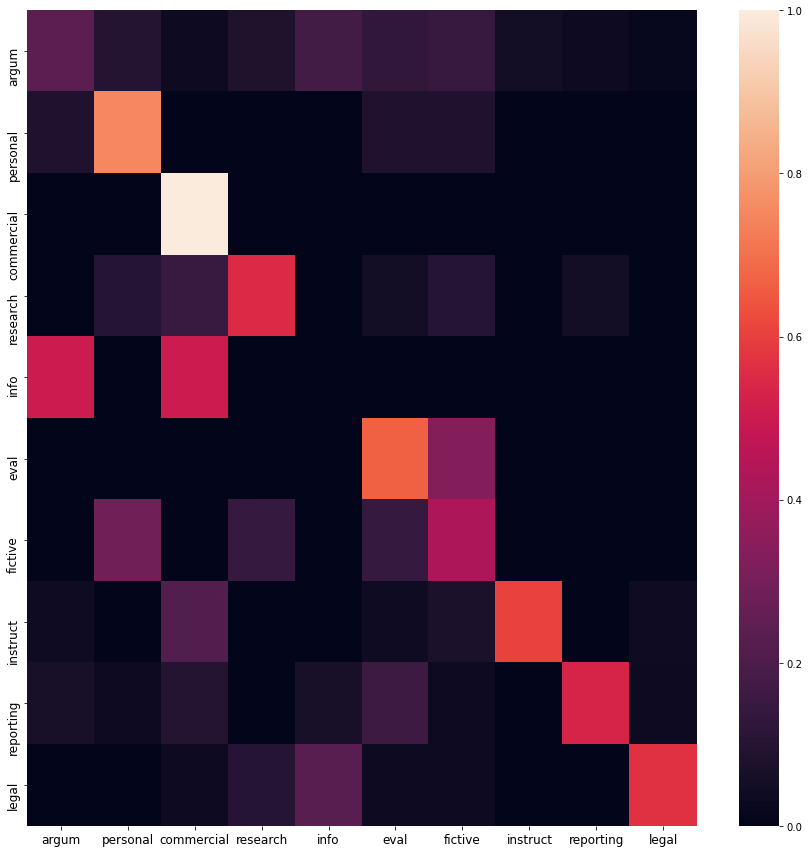

In [42]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [25]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [ ]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [ ]:
interpret_sentence(
    sentences[mistake_ids[0]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

In [ ]:
interpret_sentence(
    sentences[mistake_ids[1]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

In [ ]:
interpret_sentence(
    sentences[mistake_ids[2]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)